# Forward Modeling

> Joseph P. Vantassel, [jpvantassel.com](https://www.jpvantassel.com/)

This notebook allows the user to practice forward modeling. _Forward modeling_ is the process of interactively selecting a ground model in order to fit the theoretical dispersion data associated with the assumed ground model to the experimental dispersion data. In other words, forward modeling is a method for inverting experimental dispersion data where you (the analyst) acts as the inversion engine. While forward modeling was quite common in the past, over the last two decades more-rigorous search algorithms have replaced the use of forward modeling. Nonetheless, the process of inverting an experimental dispersion data via forward modeling remains a valuable exercise to provide intuition regarding the relationship between an assumed ground model and its theoretical dispersion curve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from disba import PhaseDispersion
import pandas as pd
import swprepost

## Cases

This notebook includes several different sets of experimental dispersion data with increasing difficulty:

- Case 1: Synthetic normally dispersive data with provided solution.
- Case 2: Experimental normally dispersive data without a provided solution. (Site Name: CUSSO)
- Case 3: Experimental normally dispersive data without a provided solution. (Site Name: WGHS)
- Case 4: Synthetic inversely dispersive data with a provided solution.
- Case 5: Experimental inversely dispersive data without a provided solution. (Site Name: A2)

In [2]:
# select your case
case = 2

available_cases = [1, 2, 3, 4, 5]
if case not in available_cases:
    raise ValueError(f"The selected case '{case}' is not available, select from {available_cases}")
else:
    print(f"You selected Case {case}.")

You selected Case 2.


## Load and Plot the Experimental Dispersion Data

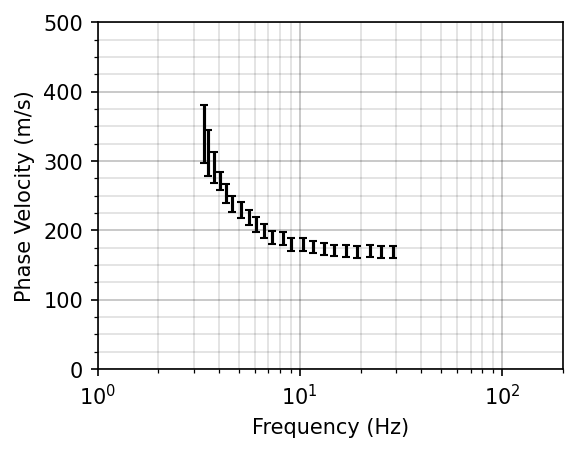

In [17]:
# load target data
target = swprepost.ModalTarget.from_csv(f"case_{case}_dispersion.csv")

# plot target data
fig, ax = target.plot(figkwargs=dict(figsize=(4,3)))
ax.margins(0.2)
ylim = ax.get_ylim()
ax.set_ylim(0, (max(ylim)//100 + 1) * 100)
ylim = ax.get_ylim()
ax.set_yticks(np.arange(0, max(ylim)+25, 25), minor=True)
ax.grid(axis="both", which="major", color="black", lw=0.2)
ax.grid(axis="both", which="minor", color="black", lw=0.1)
ax.set_xlim(1, 200)
frequency_limits = ax.get_xlim()
phase_velocity_limits = ax.get_ylim()
plt.show()

## Load and Plot the Selected Ground Model to Forward Model

In [18]:
def Insert_row(row_number, df, row_value):
    df1 = df[0:row_number]
    df2 = df[row_number:]
    df1.loc[row_number]=row_value
    df_result = pd.concat([df1, df2])
    df_result.index = [*range(df_result.shape[0])]
  
    return df_result

In [61]:
df1 = pd.read_csv("model_input.csv").dropna()
row_number = 2
row_value = [20, 1500, 250, 2000]
 
#df = Insert_row(row_number, df1, row_value)
df = df1

In [62]:
df

,Thickness [m],Vp [m/s],Vs [m/s],Density [kg/m3]
0,2,1500,170,2000
1,5,1500,175,2000
2,7,1500,192,2000
3,12,1500,260,2000
4,15,1500,315,2000
5,0,1500,500,2000


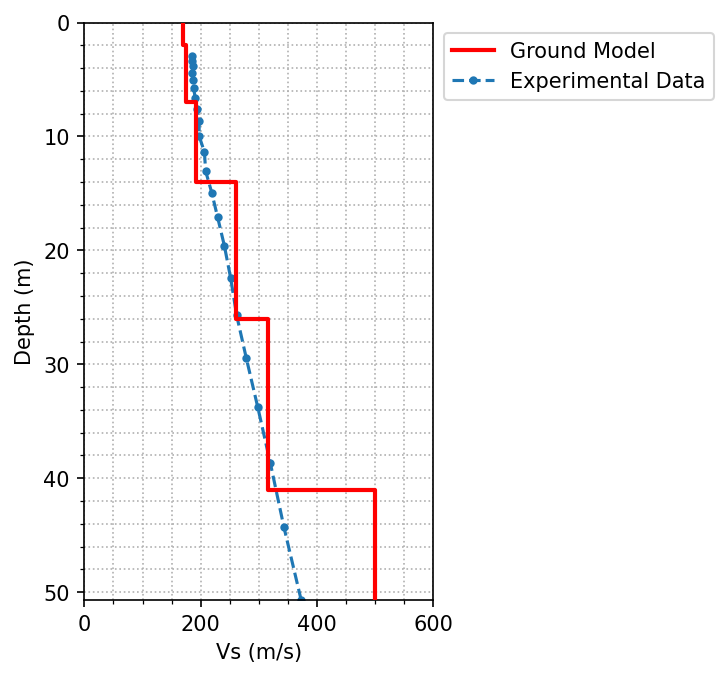

In [63]:
# read model from .csv
gm = swprepost.GroundModel(thickness=df["Thickness [m]"], vp=df["Vp [m/s]"],
                           vs=df["Vs [m/s]"], density=df["Density [kg/m3]"])
fig, ax = plt.subplots(figsize=(3, 5), dpi=150)
ax.plot(gm.vs2, gm.depth, color="red", lw=2, label="Ground Model", zorder=4)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.plot(target.pseudo_vs(velocity_factor=1.1), target.pseudo_depth(depth_factor=2), marker="o", ls="--", markersize=3, label="Experimental Data")
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Vs (m/s)")

ax.set_ylim(max((max(target.wavelength)/2, sum(gm.thickness)+15)), 0)
ylim = ax.get_xlim()
ax.set_yticks(np.arange(0, max(ylim)+10, 10))
ax.set_yticks(np.arange(0, max(ylim)+2, 2), minor=True)
ax.set_ylim(max(target.wavelength / 2), 0)

ax.set_xlim(0, 600)
xlim = ax.get_xlim()
ax.set_xticks(np.arange(0, max(xlim)+200, 200))
ax.set_xticks(np.arange(0, max(xlim)+50, 50), minor=True)

ax.grid(which="both", ls=":")
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

## Compute and Plot Theoretical Dispersion

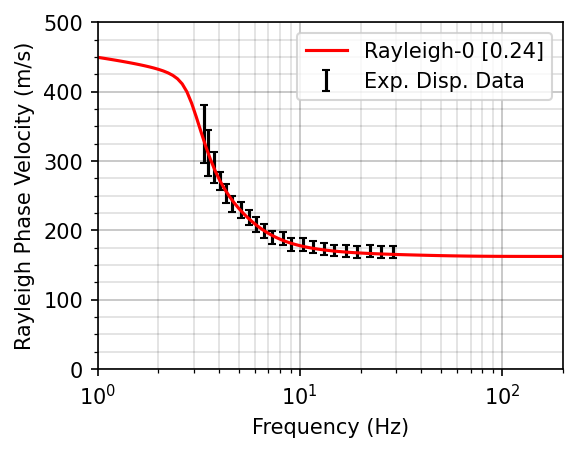

In [64]:
# Frequencies must be sorted starting with high frequencies
frequencies = np.geomspace(max(frequency_limits), min(frequency_limits), 100)

# Compute phase disperions
velocity_model = np.empty((gm.nlay, 4), dtype=float)
velocity_model[:, 0] = gm.tk
velocity_model[:, 1] = gm.vp
velocity_model[:, 2] = gm.vs
velocity_model[:, 3] = gm.rh
velocity_model_geo = velocity_model/1000
disp = PhaseDispersion(*velocity_model_geo.T)
period, velocity, *meta = disp(1/frequencies, mode=0, wave="rayleigh")
dc = swprepost.DispersionCurve(1/period, velocity*1000)

# Compute misfit
_, vel_at_tar_frq = dc.resample(target.frequency, inplace=False)
misfit = np.sqrt(np.mean((vel_at_tar_frq - target.velocity)**2 / target.velstd**2))

# Plot experimental and theoretical dispersion
fig, ax = target.plot(figkwargs=dict(figsize=(4,3)))
ax.margins(0.2)
ax.plot(dc.frequency, dc.velocity, color="red", label=f"Rayleigh-0 [{misfit:.2f}]")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Rayleigh Phase Velocity (m/s)")
ax.legend(loc="upper right")
ax.set_yticks(np.arange(0, max(ylim)+25, 25), minor=True)
ax.grid(axis="both", which="major", color="black", lw=0.2)
ax.grid(axis="both", which="minor", color="black", lw=0.1)
ax.set_xlim(frequency_limits)
ax.set_ylim(phase_velocity_limits)
plt.show()

## Compare Final Vs with True Vs (If Available)

In [65]:
has_true_model = [1, 4]
if case not in has_true_model:
    print(f"Case {case} does not have a true solution.")
else:
    best_gm = swprepost.GroundModel(*velocity_model.T)
    df = pd.read_csv(f"case_{case}_model.csv").dropna()
    true_gm = swprepost.GroundModel(thickness=df["Thickness [m]"], vp=df["Vp [m/s]"],
                                    vs=df["Vs [m/s]"], density=df["Density [kg/m3]"])
    fig, ax = plt.subplots(figsize=(2, 4), dpi=150)
    ax.plot(true_gm.vs2, true_gm.depth, color="black", lw=1, label="True Model")
    ax.plot(best_gm.vs2, best_gm.depth, color="red", lw=1, label=f"Forward Model [{misfit:.2f}]")
    ax.set_xlabel("Vs (m/s)")
    ax.set_ylabel("Depth (m)")
    xlim = ax.get_xlim()
    ax.set_xlim(0, (max(xlim)//50+1)*50)
    xlim = ax.get_xlim()
    ax.set_xticks(np.arange(0, max(xlim)+50, 50), minor=True)
    ax.set_ylim((max(sum(best_gm.thickness), sum(true_gm.thickness))//5 + 1)*5, 0)
    ax.legend(loc="upper left", bbox_to_anchor =(1, 1))
    plt.show()

Case 2 does not have a true solution.
